🔄 Preparing data...
🔢 Number of folds for cross-validation: 5
🚀 Training models to get feature importances...
🏆 Top 7 important features: ['12m_call_history', 'call_history_squared', 'premium_to_calls_ratio', 'calls_per_tenure', 'tenure_at_snapshot', 'premium_tenure_interaction', 'ann_prm_amt']
📊 Performing cross-validation with top 7 features...
⏳ Fold 1...
⏳ Fold 2...
⏳ Fold 3...
⏳ Fold 4...
⏳ Fold 5...
⌛ Cross-validation completed in 25.12 seconds.
📊 Average Training RMSE: 43.1632
📊 Average Validation RMSE: 35.9445
📈 RMSE Difference (Overfitting Indicator): 7.2187
📈 Overfitting Percentage: 16.72%
📊 Average Training R²: -0.2992
📊 Average Validation R²: 0.0989
📈 R² Difference (Overfitting Indicator): -0.3981


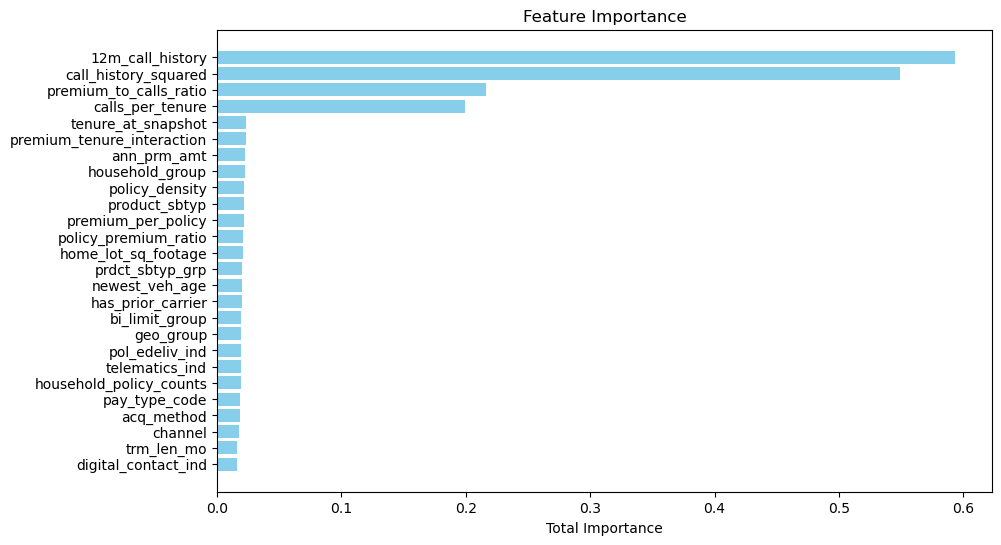

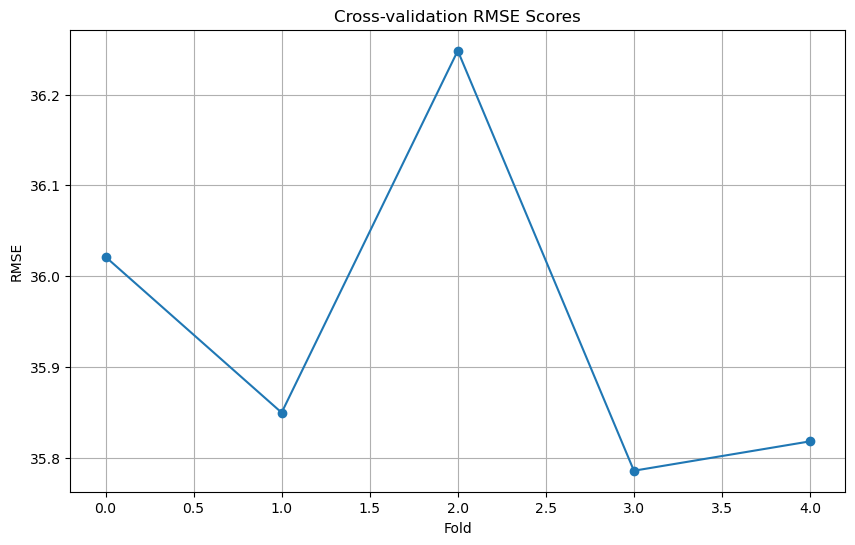

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from math import sqrt
import time
import matplotlib.pyplot as plt

# Read the data
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

# Feature Engineering
def prepare_data(df):
    data = df.copy()
    
    # Handle missing values
    for col in data.columns:
        if data[col].dtype in ['int64', 'float64']:
            data[col] = data[col].fillna(data[col].median())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])

    # Label encode categorical columns
    le = LabelEncoder()
    categorical_cols = ['acq_method', 'bi_limit_group', 'channel', 'geo_group',
                       'household_group', 'pay_type_code', 'prdct_sbtyp_grp', 'product_sbtyp']

    for col in categorical_cols:
        data[col] = le.fit_transform(data[col].astype(str))

    # Feature engineering
    data['premium_per_policy'] = np.where(
        data['household_policy_counts'] != 0,
        data['ann_prm_amt'] / data['household_policy_counts'],
        0
    )
    data['calls_per_tenure'] = data['12m_call_history'] / (data['tenure_at_snapshot'] + 1)
    data['premium_to_calls_ratio'] = np.where(
        data['12m_call_history'] != 0,
        data['ann_prm_amt'] / data['12m_call_history'],
        0
    )
    data['policy_density'] = data['household_policy_counts'] / (data['tenure_at_snapshot'] + 1)
    
    # Additional features for two-stage model
    data['premium_tenure_interaction'] = data['ann_prm_amt'] * data['tenure_at_snapshot']
    data['policy_premium_ratio'] = data['household_policy_counts'] * data['ann_prm_amt']
    data['call_history_squared'] = data['12m_call_history'] ** 2
    
    return data

# Prepare the data
print("🔄 Preparing data...")
train_processed = prepare_data(train)
test_processed = prepare_data(test)

# Create binary target for first stage
train_processed['is_zero'] = (train_processed['call_counts'] == 0).astype(int)

# Split features and target
X = train_processed.drop(['id', 'call_counts', 'is_zero'], axis=1)
y_binary = train_processed['is_zero']
y_regression = train_processed['call_counts']

# Define cross-validation strategy
n_folds = 5
print(f"🔢 Number of folds for cross-validation: {n_folds}")
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Parameters for binary classification (with regularization)
binary_params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 0.007,
    'n_estimators': 3000,
    'subsample': 0.50,
    'colsample_bytree': 0.50,
    'alpha': 0.01,      # L1 regularization
    'lambda': 10.0,       # L2 regularization
    'gamma': 0.5         # Minimum loss reduction
}

# Parameters for regression model (with regularization)
regression_params = {
    'objective': 'reg:squarederror',
    'max_depth': 2,
    'learning_rate': 0.001,
    'n_estimators': 6000,
    'subsample': 0.50,
    'colsample_bytree': 0.50,
    'alpha': 0.01,      # L1 regularization
    'lambda': 10.0,       # L2 regularization
    'gamma': 0.5         # Minimum loss reduction
}

# Initialize models
binary_model = xgb.XGBClassifier(**binary_params)
regression_model = xgb.XGBRegressor(**regression_params)

# Train both models on the full dataset to get feature importances
print("🚀 Training models to get feature importances...")
binary_model.fit(X, y_binary)
regression_model.fit(X, y_regression)

# Get feature importance from both models
binary_importance = pd.DataFrame({
    'feature': X.columns,
    'binary_importance': binary_model.feature_importances_
})

regression_importance = pd.DataFrame({
    'feature': X.columns,
    'regression_importance': regression_model.feature_importances_
})

# Combine feature importance
importance = binary_importance.merge(regression_importance, on='feature')
importance['total_importance'] = importance['binary_importance'] + importance['regression_importance']
importance = importance.sort_values('total_importance', ascending=False)

# Select top 7 features
top_7_features = importance['feature'].head(7).tolist()
print(f"🏆 Top 7 important features: {top_7_features}")

# Update the feature set to only the top 7 features
X_top7 = X[top_7_features]
test_top7 = test_processed[top_7_features]

# Initialize lists to store training metrics
train_rmse_scores = []
val_rmse_scores = []
train_r2_scores = []
val_r2_scores = []

# Re-run the cross-validation using only the top 7 features
cv_predictions_top7 = np.zeros(len(test_processed))

print("📊 Performing cross-validation with top 7 features...")
start_time = time.time()
for fold, (train_idx, val_idx) in enumerate(kf.split(X_top7), 1):
    print(f"⏳ Fold {fold}...")
    
    X_train, X_val = X_top7.iloc[train_idx], X_top7.iloc[val_idx]
    y_binary_train, y_binary_val = y_binary.iloc[train_idx], y_binary.iloc[val_idx]
    y_regression_train, y_regression_val = y_regression.iloc[train_idx], y_regression.iloc[val_idx]
    
    # Train binary model
    binary_model.fit(X_train, y_binary_train)
    
    # Get binary predictions
    binary_pred_val = binary_model.predict_proba(X_val)[:, 1]
    binary_pred_test = binary_model.predict_proba(test_top7)[:, 1]
    
    # Train regression model on non-zero samples
    non_zero_mask_train = (y_regression_train > 0)
    X_train_nonzero = X_train[non_zero_mask_train]
    y_regression_train_nonzero = y_regression_train[non_zero_mask_train]
    
    regression_model.fit(X_train_nonzero, y_regression_train_nonzero)
    
    # Make regression predictions
    regression_pred_val = regression_model.predict(X_val)
    regression_pred_test = regression_model.predict(test_top7)
    
    # Combine predictions
    final_pred_val = (1 - binary_pred_val) * regression_pred_val
    final_pred_test = (1 - binary_pred_test) * regression_pred_test
    
    # Calculate RMSE for training and validation sets
    train_rmse = sqrt(mean_squared_error(y_regression_train, regression_model.predict(X_train)))
    val_rmse = sqrt(mean_squared_error(y_regression_val, final_pred_val))
    
    train_rmse_scores.append(train_rmse)
    val_rmse_scores.append(val_rmse)

    # Calculate R-squared for training and validation
    train_r2 = r2_score(y_regression_train, regression_model.predict(X_train))
    val_r2 = r2_score(y_regression_val, final_pred_val)

    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

    # Add to test predictions
    cv_predictions_top7 += final_pred_test / n_folds

end_time = time.time()
total_time = end_time - start_time
print(f"⌛ Cross-validation completed in {total_time:.2f} seconds.")

# Calculate averages
mean_train_rmse = np.mean(train_rmse_scores)
mean_val_rmse = np.mean(val_rmse_scores)
mean_train_r2 = np.mean(train_r2_scores)
mean_val_r2 = np.mean(val_r2_scores)

# Calculate RMSE difference and percentage
rmse_difference = mean_train_rmse - mean_val_rmse
if mean_train_rmse > 0:  # Prevent division by zero
    overfitting_percentage = (rmse_difference / mean_train_rmse) * 100
else:
    overfitting_percentage = None  # Handle case where training RMSE is zero

# Print out the metrics
print(f"📊 Average Training RMSE: {mean_train_rmse:.4f}")
print(f"📊 Average Validation RMSE: {mean_val_rmse:.4f}")
print(f"📈 RMSE Difference (Overfitting Indicator): {rmse_difference:.4f}")
if overfitting_percentage is not None:
    print(f"📈 Overfitting Percentage: {overfitting_percentage:.2f}%")

print(f"📊 Average Training R²: {mean_train_r2:.4f}")
print(f"📊 Average Validation R²: {mean_val_r2:.4f}")
print(f"📈 R² Difference (Overfitting Indicator): {mean_train_r2 - mean_val_r2:.4f}")

# Create a submission file using top 7 feature model
submission_top7 = pd.DataFrame({
    'id': test_processed['id'],
    'Predict': cv_predictions_top7
})

# Ensure predictions are non-negative
submission_top7['Predict'] = np.maximum(0, submission_top7['Predict'])

submission_top7.to_csv('submission_top7_features.csv', index=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['total_importance'], color='skyblue')
plt.xlabel('Total Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Plotting CV RMSE scores
plt.figure(figsize=(10, 6))
plt.plot(val_rmse_scores, marker='o', linestyle='-')
plt.title('Cross-validation RMSE Scores')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()